# Analysis of the White Fronted Goose (Anser albifrons) and Associated Subspecies

Author: Waley Wang


In [17]:
#
# Import nessesary libraries and do nessesary non-df related prepwork
#

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime


import warnings

import GooseUtils


# Supress warning related to data types (will get on first import of the csv file)
warnings.filterwarnings("ignore", category=pd.errors.DtypeWarning)
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

Import and trim relevant data. This notebook focuses only on data related to the Anser albifrons (species id: 1710) and its subspecies Anser albifrons elgasi (species id: 1719). This roughly corresponds to $222,322$ rows of data.

In [2]:
#
# Retrieve the data from the csv file and filter out irrelevant species
#

# Retrieve group 1 data from the relevant CSV file
goose_data_raw = pd.read_csv('Bird_Banding_Data/NABBP_2023_grp_01.csv')

# Filter out all irrelevant species
goose_data_raw = goose_data_raw[(goose_data_raw['SPECIES_ID'] == 1710) | (goose_data_raw['SPECIES_ID'] == 1719)]

In [3]:
#
# Get all relevant columns and display basic information about the data
#

# Retrieve all relevant columns
goose_data = goose_data_raw[['BAND', 
                             'ORIGINAL_BAND', 
                             'OTHER_BANDS', 
                             'EVENT_DATE', 
                             'EVENT_DAY', 
                             'EVENT_MONTH', 
                             'EVENT_YEAR', 
                             'LAT_DD', 
                             'LON_DD', 
                             'COORD_PREC']]

# Display number of non-null entries in each column
print(f'Rows: {goose_data.shape[0]}')

Rows: 222322


## 1: Data Cleaning

Here all irrelevant entries in the data are filtered out and the data is formatted for use.

### 1.1: Formatting Date

A large number of the date cells (~ $3,295$) do not work with the `pd.to_datetime()` function. Since this is vital information for the analysis, the below cell aims specifically to clean the dates and remove any unessesary columns after. The following is the process by which dates are chosen.

1. If the `'EVENT_DATE'` column already has a valid date that works with `pd.to_datetime()`, it will be the date used.
2. Otherwise, if the `'EVENT_DAY'`, `'EVENT_MONTH'`, and `'EVENT_YEAR'` column all form a date that works with `pd.to_datetime()`, it will be the date used.
3. If neither of the above work, `NaT` will be assigned and the row will be dropped.


The `'EVENT_DAY'`, `'EVENT_MONTH'`, and `'EVENT_YEAR'` columns are all updated with the relevant information (will be used for grouping later).

In [4]:
#
# Clean time-related columns as described above.
#

# Attempt to apply pd.to_datetime() to the EVENT_DATE column.
goose_data['EVENT_DATE'] = pd.to_datetime(goose_data['EVENT_DATE'], format='%m/%d/%Y', errors='coerce')

# Assemble date guesses from the EVENT_MONTH, EVENT_DAY, and EVENT_YEAR columns.
dates_from_columns = pd.to_datetime(goose_data['EVENT_MONTH'].apply(str) + '/' + goose_data['EVENT_DAY'].apply(str) + '/' + goose_data['EVENT_YEAR'].apply(str), format='%m/%d/%Y', errors='coerce')

# Fill in all NaT values that can be filled with the guesses from the previous line.
goose_data['EVENT_DATE'] = goose_data['EVENT_DATE'].fillna(dates_from_columns)

# Remove all rows where EVENT_DATE is still NaT after the above operations.
goose_data = goose_data[goose_data['EVENT_DATE'].notna()]

# Ammend the EVENT_DAY, EVENT_MONTH, and EVENT_YEAR columns based on the EVENT_DATE column.
goose_data['EVENT_DAY'] = goose_data['EVENT_DATE'].apply(lambda x: x.day)
goose_data['EVENT_MONTH'] = goose_data['EVENT_DATE'].apply(lambda x: x.month)
goose_data['EVENT_YEAR'] = goose_data['EVENT_DATE'].apply(lambda x: x.year)

print(f'Rows: {goose_data.shape[0]}')

Rows: 219027


### 1.2: Formatting Coordinates and Deriving a Coordinate Uncertainy

Location data is also vital for analysis, so abit of cleaning will have to be done.

First, rows fitting any of the following conditions will be excluded:
1. Rows that do not have values for either `LAT_DD` or `LON_DD` because this issue cannot be rectified.
2. Rows whose `COORD_PREC` values are `8`, `12`, `18`, `28`, `33`, `38`, `72`, or `NaN` because an uncertainty given either cannot be determined or is too big to be useful (Corresponds to $\sim 1015$ entries).

In [5]:
#
# Clean the coordinates columns as described above.
#

# Filter out all rows where LAT_DD or LON_DD are NaN. Cannot rectify rows with this issue.
goose_data = goose_data[goose_data['LAT_DD'].notna() & goose_data['LON_DD'].notna()]

# Filter out all rows with unusable or useless coordinate precision values as outlined above.
goose_data = goose_data[~((goose_data['COORD_PREC'] == 8)  | \
                     (goose_data['COORD_PREC'] == 12) | \
                     (goose_data['COORD_PREC'] == 18) | \
                     (goose_data['COORD_PREC'] == 28) | \
                     (goose_data['COORD_PREC'] == 33) | \
                     (goose_data['COORD_PREC'] == 38) | \
                     (goose_data['COORD_PREC'] == 72) | \
                     (goose_data['COORD_PREC'].isna()))]

goose_data = goose_data[(goose_data['LAT_DD'] != 0.0) | (goose_data['LON_DD'] != 0.0)]

print(f'Rows: {goose_data.shape[0]}')

Rows: 218011


Additionally, a new column with lattitude and longitude uncertainties will be made whose values obey the following rules:
1. If the `COORD_PREC` corresponds to an exact location (is `0`), then the uncertainty is $5*10^{6}$ to account for limits in the number of significant digits given by the data.
2. If the `COORD_PREC` corresponds to a 1-minute block (is `1`), then the uncertainty is $\frac{1}{120} \approx 0.01$ degrees (rounded up) since the coordinates are in the centroid of the block.
3. If the `COORD_PREC` corresponds to a 10-minute block (is `10`), then the uncertainty is $\frac{1}{12} \approx 0.1$ degrees (rounded up) since the coordinates are in the centroid of the block.
4. If the `COORD_PREC` corresponds to a 1-degree block (is `60`), then the uncertainty is $0.5$ degrees since the coordinates are in the centroid of the block.
5. If the `COORD_PREC` corresponds to a county (is `7`), then the uncertainty will be $0.25$ degrees by estimate (since the average county land area is 1090.69 degrees and a sqaure of that size is around $0.5$ degrees in lattitude and longitude)
6. If the `COORD_PREC` corresponds to a town/area (is `11`), then the uncertainty will be $0.25$ degrees by estimate (since each town should be smaller than a county and thus have less uncertainty associated with it)

In [6]:
#
# Perform the coordinate precision conversion as described above.
#

# Compute coording uncertainties
goose_data['COORD_UNC'] = goose_data['COORD_PREC'].apply(lambda x : GooseUtils.get_coord_unc(x))

# Drop the old column
goose_data = goose_data.drop(labels=['COORD_PREC'], axis=1)

## 2: Perliminary Analysis

### 2.1: Questions Related to Migration Patterns

#### 2.1.1: Question 1: Does the White Fronted Goose Move Over the Course of a Year?

For this, we will compare the median location of the bird over all datapoints taken within each month of the year. The median location here will be defined as the location whose lattitude is the median lattitude and whose longitude is the meadian longitude. We will also define locations being significantly different to mean that either the lattitude or longitude differs significantly.

For this question, we will first handle the following hypotheses:

Null Hypothesis ($H_0$): There is no significant differnce between the median positions of the White Fronted Goose between any two months.

Alternate Hypothesis ($H_A$): This is a significant differnce between the median positions of the White Fronted Goose between any two months.

In [7]:
#
# Group the data by EVENT_MONTH to prepare for further analysis
#
months_dict = goose_data.groupby('EVENT_MONTH')

In [27]:
#
# Perform the Kruskal-Wallis test on latitude and longitude data
#

# Prepare lists containing lattidue and longitude data from each month
lat_smaple = [group['LAT_DD'].values for _, group in months_dict]
lon_sample = [group['LON_DD'].values for _, group in months_dict]

# Perform the Kruskal-Wallis test on latitude and longitude data
lat_stat, lat_p_value = stats.kruskal(*lat_smaple)
lon_stat, lon_p_value = stats.kruskal(*lon_sample)

# Print out the results
print(f"Kruskal-Wallis test statistic for lattitude: {lat_stat}, p-value: {lat_p_value}")
print(f"Kruskal-Wallis test statistic for longitude: {lon_stat}, p-value: {lon_p_value}")

Kruskal-Wallis test statistic for lattitude: 136860.7761259745, p-value: 0.0
Kruskal-Wallis test statistic for longitude: 54961.0445827825, p-value: 0.0


As seen above, the Kruskal-Wallis statistic is around $137,000$ for lattitude and around $55,000$ for longitude. This corresponds with extremely small $p$ values for both lattitude and longitude (both too small for Python to properly store). This means that the median location of the White Fronted Goose differs significantly between at least two months since the $p$ value is clearly smaller than $0.05$, the threshold required to reject the null hypothesis $H_0$. Therefore we can only conclude that $H_A$ is true.

Since $H_0$ was rejected, a post-hoc analysis is at hand. This will be a series of $\frac{12(12+1)}{2} = 66$ sets of null and alternate hypotheses (denoted as $H_{(0, i, j)}$ and $H_{(A, i, j)}$ for $i, j \in \{1, 2, ..., 12 \} | i \neq j$) defined as follows:

Null Hypothesis ($H_{(0, i, j)}$): The median position in month $i$ does not differ significantly from $j$.

Alternate Hypothesis ($H_{(A, i, j)}$): The median position in month $i$ differs significantly from $j$.

This will be tested with Mann-Witney U Tests. The condition for rejecting the null is set to be $p < 0.05$ for either lattitude or longitude.

In [ ]:
#
# Perform the Mann-Whitney U test for each pair of months
#

# Initialize a 12x12 matrix to store the results of the Mann-Whitney U test
mann_whitney_results = np.full((12, 12), None, dtype=object)

# Perform the Mann-Whitney U test for each relevant pair of months
for i in range(0, 12):
    for j in range(i + 1, 12):
        lat_stat, lat_p_value = stats.mannwhitneyu(months_dict.get_group(i + 1)['LAT_DD'], months_dict.get_group(j + 1)['LAT_DD'], alternative='two-sided')
        lon_stat, lon_p_value = stats.mannwhitneyu(months_dict.get_group(i + 1)['LON_DD'], months_dict.get_group(j + 1)['LON_DD'], alternative='two-sided')
        mann_whitney_results[i][j] = (lat_stat, lat_p_value, lon_stat, lon_p_value)

# Store the results into a DataFrame for better visualization
mann_whitney_df = pd.DataFrame(mann_whitney_results, index=range(1, 13), columns=range(1, 13))

# Extract the relevant statistics and p-values from the DataFrame
mw_lat_stat_df = mann_whitney_df.map(lambda x: x[0] if x is not None else None)
mw_lat_p_df = mann_whitney_df.map(lambda x: x[1] if x is not None else None)
mw_lon_stat_df = mann_whitney_df.map(lambda x: x[2] if x is not None else None)
mw_lon_p_df = mann_whitney_df.map(lambda x: x[3] if x is not None else None)

# Table whose values correspond to whether the null hypothesis can be rejected for each pair of months
mw_lat_h0_reject_df = mann_whitney_df.map(lambda x: x[1] < 0.05 if x is not None else None)
mw_lon_h0_reject_df = mann_whitney_df.map(lambda x: x[3] < 0.05 if x is not None else None)
mw_h0_reject_df = mann_whitney_df.map(lambda x: x[1] < 0.05 and x[3] < 0.05 if x is not None else None)

# Display the results
#     True  -> Reject Null
#     False -> Fail to Reject
#      None -> Not Tested
display(mw_h0_reject_df)

,1,2,3,4,5,6,7,8,9,10,11,12
1,False,True,True,True,True,True,True,True,True,True,True,True
2,False,False,True,True,True,True,True,True,True,True,False,True
3,False,False,False,True,True,True,True,True,True,True,True,True
4,False,False,False,False,True,True,True,True,True,True,True,True
5,False,False,False,False,False,True,True,True,True,True,True,True
6,False,False,False,False,False,False,True,True,True,True,True,True
7,False,False,False,False,False,False,False,True,True,True,True,True
8,False,False,False,False,False,False,False,False,True,True,True,True
9,False,False,False,False,False,False,False,False,False,False,True,True
10,False,False,False,False,False,False,False,False,False,False,True,True


It seems that there is a difference between all pairs of distinct months. Therefore we can conclude that the White Fronted Goose does move over the course of a year. The difference becomes more apparant when looing at scatter plots of the lattitude and longitude based on date (excluding year).

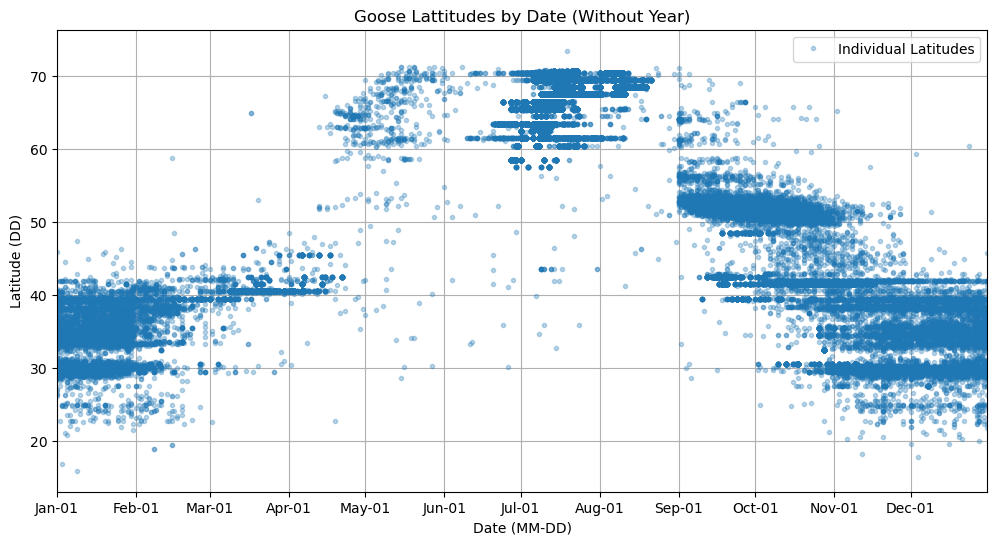

In [ ]:
#
# Plot lattitudes by month.
#

fig, ax = plt.subplots(figsize=(12, 6))

meadian_lats = [group['LAT_DD'].median() for _, group in months_dict]
ax.plot(goose_data['EVENT_DATE'].apply(lambda x : x.replace(year = 2000)), goose_data['LAT_DD'], marker='.', linestyle='None', alpha=0.3, label='Individual Latitudes')
fmt = mdates.DateFormatter("%b-%d")
ax.xaxis.set_major_formatter(fmt)
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.set_xlim([datetime(2000, 1, 1), datetime(2000, 12, 31)])
ax.set_xlabel('Date (MM-DD)')
ax.set_ylabel('Latitude (DD)')
ax.legend()
ax.set_title('Goose Lattitudes by Date (Without Year)')
ax.text(0.5, -0.15, 'Lattitudes of bird events by date without considering the year.')
ax.grid()

plt.show()

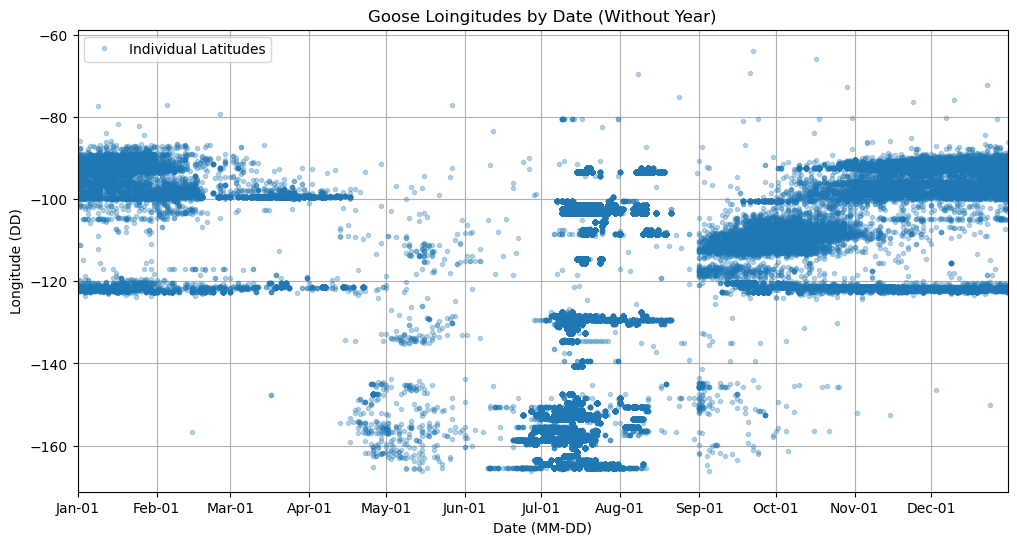

In [ ]:
#
# Plot longitudes by month.
#

fig, ax = plt.subplots(figsize=(12, 6))

meadian_lats = [group['LON_DD'].median() for _, group in months_dict]
ax.plot(goose_data['EVENT_DATE'].apply(lambda x : x.replace(year = 2000)), goose_data['LON_DD'], marker='.', linestyle='None', alpha=0.3, label='Individual Latitudes')
fmt = mdates.DateFormatter("%b-%d")
ax.xaxis.set_major_formatter(fmt)
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=1))
ax.set_xlim([datetime(2000, 1, 1), datetime(2000, 12, 31)])
ax.set_xlabel('Date (MM-DD)')
ax.set_ylabel('Longitude (DD)')
ax.legend()
ax.set_title('Goose Loingitudes by Date (Without Year)')
ax.grid()
plt.show()